# vary tophat max mode order and get times

In [1]:
#  Automated import
import sys
import os
sys.path.append('..')

from hg_scripts.setup_imports import *



In [2]:
#expansion orders
sh_order = 1
ti_order = 7

#terms in xp matrix
xpfile = dict_from_xpfile('x_p_file')
sols_matrix = xpfile[str(sh_order)+'_shift_'+str(ti_order)+'_tilt']
# print(sols_matrix)
xpfile.clear()

In [3]:
xtran_file = build_symbolic_dictionary(n_max=40,p_max=10,x_max=10)

..\hg_scripts\transverse_coord_transform.py:143: RuntimeWarning: invalid value encountered in sqrt
  item.n_coeff += "*"+str(Sqrt(item.N+1))


In [4]:
th_coeff_fn = 'inputs/tophat_coefficients/paul_coef_file.mat'
waist = (.8)*1e-3
max_order = 3
numberModes = max_order**2
modes = truncated_tophat(th_coeff_fn,waist,numberModes)
pl.show_modes(modes)

n\m [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
0   [0.0008354396440422367, 0.0, 0.0005894326084793833, 0.0, 0.0005013708372668804, 0.0, 0.0004192969089074639, 0.0, 0.0002883670228423947, 0.0]
1   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0]
2   [0.0005894326084793833, 0.0, 0.00040936757440527915, 0.0, 0.00032478598906297124, 0.0, 0.00021798497964373075, 0.0, 0, 0]
3   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0]
4   [0.0005013708372668804, 0.0, 0.0003247859890629713, 0.0, 0.00020679870941388878, 0.0, 0, 0, 0, 0]
5   [0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0]
6   [0.0004192969089074639, 0.0, 0.00021798497964373032, 0.0, 0, 0, 0, 0, 0, 0]
7   [0.0, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0]
8   [0.0002883670228423947, 0.0, 0, 0, 0, 0, 0, 0, 0, 0]
9   [0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [15]:
#represents the sums
def update_modes (z,params,a,b,modes,sols_matrix):
    
    #get params
    K = params.getK()
    w0 = params.getW0()
    zr = params.getZr()
    w = pl.w(z,params)
    gouy = pl.gouy_phase(z,params) 
    R = pl.radius_curvature(z,params)
    
    #build new modes (up to 2 orders larger for quad. dep.)
    rows = len(modes)
    cols = len(modes[0])  
    number_modes = rows*cols
    exp_order = len(sols_matrix)
    new_modes = [[0 for m in range(cols+exp_order)] for n in range(rows+exp_order)]
    
    #placeholders
    x=1
    j=1j
    p=e**(1j*gouy)
    
    #calculate all coupling factors a->e\d
       
    for n in range(len(modes)):
        for m in range(len(modes[n])):
            if (modes[n][m]!=0): #break if c_nm = 0
                c_nm = modes[n][m] #assign c_nm

                for x_order in range(len(sols_matrix[0])):
                    for p_order in range(len(sols_matrix)):
                        if(sols_matrix[x_order][p_order]!='' and (p_order<=n) ):
                            #append each element in x,p matrix to coupling list
                            coupling = eval(sols_matrix[x_order][p_order])*(p**(p_order))
                            
                            if(x_order>0):
                                key = 'n'+str(n)+'p'+str(p_order)+'x'+str(x_order)
                                q = xtran_file[key]
                                #print(n_start,x_order)
                                #empty the q
                                for item in q:
                                    X = eval(item.overall) #just x coupling
                                    N = item.N #final n order
                                    #print("N,x_order,p_order,n,m",N,x_order,p_order,n,m)
                                    if(N>=0):
                                        new_modes[N][m]+= c_nm*coupling*X

                            #N is either n or n-p_order, no x-dependence
                            else:
                                N= n-p_order
                                #print("N,x_order,p_order,n,m",N,x_order,p_order,n,m)
                                new_modes[N][m]+= c_nm*coupling                            
# return(new_modes,ind_list)
    return(new_modes)

In [16]:
# mat = scipy.io.loadmat('Top_hat_for_paul.mat')
mat = scipy.io.loadmat('inputs/tophat_coefficients/paul_coef_file.mat')
for x in mat:
  print(x)
coef=mat['coeftopUnitInt'].ravel()
print(mat['readmepaul'])
# coef=mat['coeftop'].ravel()

def N_f(A):
    
    res = np.floor((np.sqrt(8*A+1)-1)/2)
    
    #res = (np.sqrt(9+8*A)-3)/2
    return(res)

def m(N,A):
    res = (N+1)*(N+2)/2 - (A+1)
    return(res)

#def n(N,A):
#    m= (N+1)*(N+2)/2 - (A+1)
#    res = N-m
#    return(res)
def n(N,A):
    res = A - (N*(N+1)/2)
    return(res)

NumberModes = int(len(coef))
listModesN = [None] * NumberModes
listModesM = [None] * NumberModes
listModesC = [None] * NumberModes

area = pi*1e-3**2

#for i in range(len(coef)):
#    A=i
#    N= N_f(A)
#
#    if (m(N,A)%2 == 0) & (n(N,A)%2 == 0):
#        print(coef[A], '\t\t\t' , m(N,A), ',' , n(N,A))

for i in range(NumberModes):
    A=i
    N= N_f(A)
    listModesN[i] = int(m(N,A))
    listModesM[i] = int(n(N,A))
    listModesC[i] = coef[i]
    
top_modes = pl.create_modes(listModesM,listModesN,listModesC,NumberModes)

params = pl.Params(1064e-9,.8e-3,0)
plane = pl.Plane(-2e-3,2e-3,101,-2e-3,2e-3,101)
# temp_modes=rotate_RX(10e-3,params,10e-3,0,modes)
# pl.show_modes(modes)
# calc=pl.calculate(params,plane,top_modes,0)
# #plot
# fig, ax = plt.subplots(figsize=(12, 12))
# cs = plt.contourf(calc.plane.getX(), calc.plane.getY(), abs(calc.getAmp() ** 2))

# ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0), useMathText=True)
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText=True)

# plt.xlim([-1e-3,1e-3])
# plt.ylim([-1e-3,1e-3])

# cbar = fig.colorbar(cs)

# plt.grid()


__header__
__version__
__globals__
coeftopUnitInt
coeftopUnitPow
readmepaul
['Two tophat coefficient variables, one for unit power and one for \n unit intensity, should be clear from the name which is which.\nAgain these assume a waist 1/3 of a mm.']


In [17]:
#loop through and sum over modes overlap where a,b -> n,m
def iterate_modes_overlap(w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1,x_2,Z,Y,modes,s):   
    
    N = len(modes)
    M = len(modes[0])
    res_arr = [[0 for i in range(10)] for j in range(10)]
    res = 0

    for a in range(N):
        for b in range(M):            
            #ignore zero coeff.
            if (modes[a][b]!=0):
                c_nm = modes[a][b]
                #result is the sum of all overlap coefficients each with a factor of mode coefficient
                res += ( c_nm * th.overlap(a,b,w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1,x_2,Z,Y) )
                
    return(res)

In [18]:


def signals(v):
    #points determine size of arrays (equivalent to # data points plotted)
    points = v.points
    time_start = process_time()

    time_ave1 = 0
    time_ave2 = 0
    
    s= (
        1/(v.w_1**2 *(1+(1j)*v.d_1/v.zR_1))
        +
        1/((v.w_2**2 *(1-(1j)*v.Z/v.zR_2)))
    )

    #modes_arr = [0]*points
    cl = [0]*points
    cr = [0]*points
    phi_l = [0]*points
    phi_r = [0]*points
    dws = [0]*points
    lps = [0]*points
    total_lps = [0]*points


    #alpha_arr = np.linspace(-500e-6,500e-6,points)
    

    pbar = ProgressBar(widgets=[Percentage(), Bar()], maxval=points).start()

    
    
    for p in range(points):
        time_ave_start1 = process_time()
        #shift x+zsina
        new_modes = update_modes(v.z,v.params,v.a,v.alpha_arr[p],modes_0,sols_matrix)
        
        print(new_modes)
        time_ave_start2 = process_time()
        #create arrays of overlap coefficients left and right
        cl[p] = iterate_modes_overlap(v.w_1,v.w_2,v.zR_1,v.zR_2,v.k_1,v.k_2,v.d_1,v.W_2,v.x_1L,v.x_2L,v.Z,v.Y,new_modes,s) # left overlap (-2e-3,0)

        cr[p] = iterate_modes_overlap(v.w_1,v.w_2,v.zR_1,v.zR_2,v.k_1,v.k_2,v.d_1,v.W_2,v.x_1R,v.x_2R,v.Z,v.Y,new_modes,s) # right overlap (0,2e-3)
        time_ave1 += (process_time()-time_ave_start1)
        time_ave2 += (process_time()-time_ave_start2)

        #create arrays of phases for left and right coeff.
        phi_r[p]=angle(cr[p])
        phi_l[p]=angle(cl[p])
        
        #create arrays of dws &lps for phases in phase arrays
        dws[p] = (phi_r[p]-phi_l[p])
        lps[p] = 0.5*(phi_r[p]+phi_l[p])/v.k_1 *1e9
        total_lps[p] = angle(cr[p]+cl[p])/v.k_1 *1e9
        
        pbar.update(p+1)
        
    pbar.finish()
    
    #total time for all DWS & LPS points (not including scattering)
    time_elapsed = (process_time() - time_start)
    print(time_elapsed,'s')
    print(time_ave1/p,'s',time_ave2/p,'s')
    
    return(dws,lps,total_lps)

num=61
waist = (.8)*1e-3
# waist = 1e-3
z=-1e-3

class Vars:
#modes,alpha with points
    def __init__(self, 
                 lam=1064e-9,
                 z_PD=-1e-3,z=-1e-3,
                 z_m=0,Z=-1e-3,
                 z_LO=0, d_1=-1e-3,
#                  z_PD=0,z=0,
#                  z_m=0,Z=0,
#                  z_LO=0, d_1=0,
                 Y=.8e-3,
                 x_1R=0e-6,x_2R=.8e-3,
                 x_1L=-.8e-3,x_2L=-0e-6,
                 w_1=.8e-3, w_2=.8e-3,
                 zR_1=pi*.8e-3**2/1064e-9,zR_2=pi*waist**2/1064e-9,
                 k_1=5905249.348852994,k_2=5905249.348852994,
                 params=pl.Params(1064e-9,waist,-1e-3),
                 W_2=1e-3,
                 points=num,
                 a=-.1e-3,alpha_arr=np.linspace(-150e-6,150e-6,num),modes_arr=[0]*num):
        self.lam = lam


        self.z_PD = z_PD #PD location
        self.z = z #prop distance assumed PD

        self.z_m = z_m #meas beam 
        self.Z = Z #distance PD-m

        self.z_LO = z_LO #Local ref. beam
        self.d_1 = d_1 #distance PD-LO


        self.Y = Y #Y int bound

        self.x_1R = x_1R
        self.x_2R = x_2R 

        self.x_1L = x_1L #assumed symmetric with right side
        self.x_2L = x_2L

        self.w_1 = w_1 #waist LO 
        self.w_2 = w_2 #waist MS

        self.zR_1 = zR_1 #rayleigh LO
        self.zR_2 = zR_2


        self.k_1 = k_1 #wavenum LO
        self.k_2 = k_2

        self.params = params #for building tophat coefficients

        self.W_2 = pl.w(z,pl.Params(1064e-9,.8e-3,1e-3)) #tophat beam rad , w(z) or 1e-3?



        #integration and misalignment
        self.points = points

        self.a = a
        self.alpha_arr = alpha_arr

        self.modes_arr = modes_arr

        #build modes from misalignments
#         for p in range (points):
#             self.modes_arr[p] = update_modes(z,params,a,alpha_arr[p],modes_0,sols_matrix) #array of array of scattered modes#array of array of scattered modes

    def setz(self,z):
        self.z = z #prop distance assumed PD
        self.z_PD = z #PD location
        
        self.Z = z-self.z_m #distance PD-m

        self.d_1 = self.z_PD-self.z_LO #distance PD-LO
    
        self.W_2 = pl.w(z,pl.Params(1064e-9,waist,-1e-3))
        
        #scattering also depends on z...
        for p in range (self.points):
            self.modes_arr[p] = [0]*p #clear modes
            self.modes_arr[p] = update_modes(z,params,a,alpha_arr[p],top_modes,sols_arr) #array of array of scattered modes#array of array of scattered modes

        


In [19]:
modes_0 = plb.modes((0,0,1))

%xmode Verbose

# z=10e-3
# params = pl.Params(1064e-9,1e-3,z)


print('Signals calculation...')
v = Vars()
dws,lps,total_lps = signals(v)


params=pl.Params(1064e-9,waist,-1e-3)
K=params.getK()



Exception reporting mode: Verbose
Signals calculation...
[[(0.9391372203423434-0.04159477113158955j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.13230928753358975-0.3327425703261658j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.08333537401626027+0.06260463599991531j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.018831490685122014+0.017034258518872376j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.0030079503150415477-0.004403657300888961j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.0008665788912456043-0.00047589546512254383j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-7.333493403353339e-05+0.00014978052593242626j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(2.4421834107907397e-05+9.796906690762828e-06j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-1.2932271189143284e-08-3.491104126860103e-06j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[(0.9430105222913073-0.04037407898572659j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.13187870087947715-0.3229779957577676j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.07819191906272349+0.06052951844939511j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.0

[[(0.9539276596405732-0.036616418468616116j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.13064250998859248-0.29291944719343255j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.06357503481907248+0.05429222595356528j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.01422141378885209+0.011261179597200428j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.0017247099184871358-0.002889208036395835j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.0004935663254348894-0.00023643443033412122j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-3.1048178004777535e-05+7.401406697833027e-05j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(1.034675340535641e-05+3.5935629294762382e-06j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-4.749407742832768e-09-1.282116399249683e-06j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[(0.9573275697393225-0.035333552841666206j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.1302506874658937-0.28265738083748077j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.058987033134712936+0.052209836131404765j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.013164458897685928+0.01004629274303409j), 0, 0, 0, 0, 0

[[(0.9696951570674659-0.030063524738278488j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.12879756205017417-0.24050030619082652j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.04215521642270339+0.0438685672176443j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.00932894293466842+0.006029856089917671j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.0007461868229110501-0.0015347739969200503j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.00021212856269170387-8.258685512144484e-05j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-8.606471084005257e-06+2.5721642985317672e-05j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(2.871913351896985e-06+8.040846328770025e-07j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-1.0650281411920628e-09-2.8750743659467497e-07j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[(0.9724727424741096-0.02871391889712837j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.12846508997994568-0.22970417267001977j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.03834453441004742+0.041781078244870574j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.008469616410940732+0.00522332337147657j), 0, 0, 0, 0, 0

[[(0.982291711323192-0.02320300004172901j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.1272708558154804-0.1856193597291058j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.024784898938952696+0.033426124316628905j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.005438254063653383+0.0027002253237406624j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.00025454609131391164-0.0006830905317014231j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-7.202919084621489e-05-2.1450632367254477e-05j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-1.6792665106626523e-06+6.660173932167873e-06j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(5.616515822306211e-07+1.1941705539018078e-07j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-1.5873251549032182e-10-4.2850303074402074e-08j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[(0.9844185557630152-0.021799894391228317j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.1270080672987239-0.174395067646771j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.021829775797189435+0.03133662004826205j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.004783008003630707+0.0022294261230780448j), 0, 0, 0, 0

[[(0.991587968495462-0.016102967465663115j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.12610975779134354-0.12882152556700127j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.011821920064817816+0.0229777419843109j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.0025780196138780304+0.0008849075567769869j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(5.73028165798883e-05-0.000222970834885972j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-1.617951509702791e-05-3.315612212558468e-06j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-1.764583080813415e-07+1.0291718888049042e-06j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(5.929180901073422e-08+8.610326123986685e-09j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-1.152324554555137e-11-3.1107335664804987e-09j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[(0.9930421110457375-0.014660517746607551j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.1259247789902989-0.11728230940800126j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.009783527079323603+0.02088807025770846j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.0021315409853407165+0.0006656166229227554j), 0, 0, 0, 0,

[[(0.9982540209141494-0.0073687024192706976j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.1252485756961583-0.0589491588102617j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.0024559805803522285+0.010441694006517404j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.0005336883107394598+8.335771325291777e-05j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(2.4445699721145e-06-2.1004304462681104e-05j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-6.932586503563114e-07-6.397205578786976e-08j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-1.5273177714216934e-09+2.005340756667458e-08j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(5.227913334275128e-10+3.361401215261534e-11j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-4.619724218801165e-14-1.2471079556970484e-11j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[(0.9988815976252056-0.00589866333806702j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.12516422653025244-0.047189011771368236j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.0015719353059979297+0.008352946905492797j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.0003416150993011473+4.263383785461882e-05j), 0, 0

[[(1+0j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.125+0j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [0j, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0j, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0j, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0j, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0j, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0j, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0j, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[(0.9999310396745418+0.0014762093769577162j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.12500246750824232+0.011809693468278957j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-9.973091866628918e-05-0.0020877165405702356j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(2.1353061106272905e-05-6.951111769640265e-07j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(4.238260614099794e-09+1.6812478831408334e-07j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-1.1099961861532366e-09+2.332555671492187e-11j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-1.1813837236146405e-13-6.422330932929018e-12j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(3.34486102264342e-14-5.577110707166809e-16j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(5.913247000065401e-19+1.5962981832921

[[(0.9988878406546997+0.005898663338066787j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.1251142822942988+0.04718960163770217j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.0015807938398201958-0.00834961011761522j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.0003414785820990928-4.3357348511636066e-05j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(1.032677554402872e-06+1.075274586112387e-05j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-2.839380762508387e-07+2.2058037692696705e-08j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-4.316788058127394e-10-6.570893171985748e-09j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(1.3698495557620388e-10-7.832432619350965e-12j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(9.688263884907338e-15+2.615374943505986e-12j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[(0.9982618198041511+0.007368702419270124j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.12518618457614242+0.05895007989806489j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.002467067568345771-0.010436483547064125j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.0005334218428921875-8.448843340941718e-05j), 0, 0,

[[(0.9943736584654903+0.013211962010439558j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.1256442584934408+0.10569718242931148j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.007954305268049694-0.018781681490214697j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.0017256842197247314-0.000489365628331092j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(2.6104921092413584e-05+0.00012217230171537733j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-7.2554075300548115e-06+1.2470714155099562e-06j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-5.4752652826414864e-08-3.776697520262094e-07j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(1.776885210674853e-08-2.2159609824743827e-09j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(2.8282877090656295e-12+7.635044725443028e-10j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[(0.993057627449939+0.014660517746598387j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.12580064775669353+0.1172859745376462j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.009805929716562632-0.02086733715350787j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.002129420364041737-0.0006701472132779238j), 0, 0, 

[[(0.9864339803855348+0.02038776221338739j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.12658764205483983+0.16310566556716552j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.01908545138996141-0.029206603607462522j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.004163414351530681-0.0018248885275665868j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.00015121838887115403+0.00045790157634754893j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-4.2266311905036e-05+1.1217631945516545e-05j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-7.706421070888096e-07-3.4205180867489845e-06j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(2.5168880207115134e-07-4.839404517668732e-08j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(6.233360862943941e-11+1.68271384929668e-08j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[(0.9844416283432765+0.021799894391182358j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.1268234866566288+0.1744032426125143j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.02186394146064745-0.031290375458590265j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.004775913026850584-0.002239647832196442j), 0, 0, 0, 0, 0

[[(0.9725031327221133+0.02871391889698486j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.1282219679959173+0.22971852968288606j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.03839110969492102-0.04169986271572908j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.008453002653573254-0.005241560843242991j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.0006198545235413332+0.0013250421470382082j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.00017447000800013468+6.562634948852818e-05j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-6.526799850297262e-06-2.015062747704585e-05j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(2.1386772716054534e-06-5.847190991519765e-07j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(7.568956160083872e-10+2.0432616746140558e-07j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[(0.9697269757117791+0.030063524738104554j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.12854301289567138+0.24051608962023782j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.04220436685503415-0.043779282658029654j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.009309765326302217-0.006049979117068728j), 0, 0, 0, 0, 0

[[(0.9573649660778281+0.03533355284132148j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.12995151675784963+0.28267946462642046j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.05904683559208024-0.05208491135633854j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.013132515039043873-0.010074910160125771j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.0014879213445001618+0.0025667726581612813j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.0004217724495980235+0.0001968283691579944j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-2.4855502520273144e-05-6.0822958662875315e-05j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(8.156364691096186e-06-2.781675406409425e-06j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(3.609159545938422e-09+9.74303090388322e-07j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[(0.9539664137388454+0.03661641846821431j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.13033247720241822+0.29294324830121105j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.06363759341140522-0.05415758655616948j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.014185608737751034-0.011292160206799915j), 0, 0, 0, 0, 0, 0

[[(0.9391812434312041+0.04159477113088911j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.1319571028227048+0.33277376777366374j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.08340935630658329-0.06242815658695865j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.018777338735548654-0.01707565853157539j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(0.003022194960873159+0.004390892904942353j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-0.0008640506731578465+0.0004796065890430592j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(-7.413323363172996e-05-0.00014931229195056797j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(2.4348678134675507e-05-9.951760524686129e-06j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [(1.2932271189143284e-08+3.491104126860103e-06j), 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
2.984375 s
0.04869791666666667 s 0.002864583333333333 s


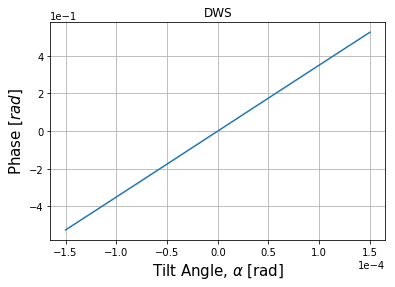

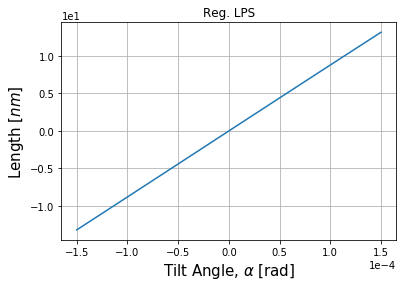

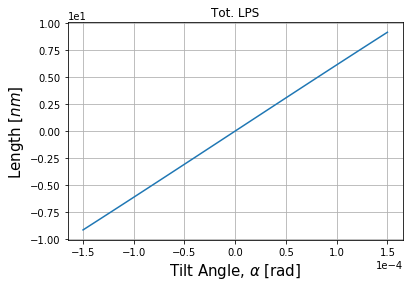

In [14]:
plot_dws(v.alpha_arr,dws)
plot_lpsR(v.alpha_arr,lps)
plot_lpsT(v.alpha_arr,total_lps)